In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import scipy
from scipy.stats import skew
from scipy.stats import kurtosis
import seaborn as sns
from warnings import filterwarnings
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sqlalchemy import create_engine
import psycopg2
import streamlit as st
import credentials
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth

/home/pkeskin/anaconda3/envs/COMP47750/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Association Rules Mining 

#### Loading dataset

In [74]:
df_Online_Retail=pd.read_excel('Online_Retail.xlsx')

In [75]:
df_Online_Retail.shape

(541909, 8)

In [76]:
df_Online_Retail.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom


## Data Cleaning

#### Discarding all rows with null values in Description and CustomerID. Removing all records with InvoiceNo starting with ‘C’.

In [77]:
dfq1=df_Online_Retail.copy()

In [78]:
missing_count_Description = dfq1['Description'].isnull().sum()
missing_count_CustomerID = dfq1['CustomerID'].isnull().sum()
print("Missing values of the column: %d out of %d" % (missing_count_Description, dfq1.shape[0]))
print("Missing values of the column: %d out of %d" % (missing_count_CustomerID, dfq1.shape[0]))

Missing values of the column: 1454 out of 541909
Missing values of the column: 135080 out of 541909


In [79]:
dfq1.shape

(541909, 8)

In [80]:
dfq1 = dfq1.dropna(subset=['Description', 'CustomerID'])

In [81]:
dfq1.shape

(406829, 8)

In [82]:
dfq1 = dfq1[~dfq1['InvoiceNo'].astype(str).str.startswith('C')]

In [83]:
dfq1.shape

(397924, 8)

#### Removing records with Description ‘POSTAGE’. Discarding records with InvoiceNo having only one item purchased.

In [84]:
dfq1 = dfq1[dfq1.Description != "POSTAGE"]

In [85]:
dfq1.shape

(396825, 8)

In [86]:
dfq1 = dfq1[dfq1.groupby(['InvoiceNo']).Quantity.transform(sum) >1]

In [87]:
dfq1.shape

(396662, 8)

#### Merging different invoices issued on the same day for same customer under one InvoiceNo. Removing items, which are sold less than 1000 in total.

In [88]:
dfq1['InvoiceDate_CustomerID']= dfq1['InvoiceDate'].dt.date.astype(str) + dfq1['CustomerID'].astype(str)

In [89]:
dfq1['InvoiceDate_CustomerID'].head(2)

0    2010-12-0117850.0
1    2010-12-0117850.0
Name: InvoiceDate_CustomerID, dtype: object

In [90]:
g=dfq1.groupby('InvoiceDate_CustomerID')['InvoiceNo'].nth(0).to_frame()
g.reset_index()

,InvoiceDate_CustomerID,InvoiceNo
0,2010-12-0112431.0,536389
1,2010-12-0112433.0,536532
2,2010-12-0112583.0,536370
3,2010-12-0112662.0,536527
4,2010-12-0112791.0,536403
...,...,...
16637,2011-12-0917428.0,581488
16638,2011-12-0917490.0,581481
16639,2011-12-0917581.0,581579
16640,2011-12-0917754.0,581514


In [91]:
dfq1=dfq1.merge(g , how='left', on='InvoiceDate_CustomerID')

In [92]:
dfq1.head(1)

,InvoiceNo_x,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_CustomerID,InvoiceNo_y
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-0117850.0,536365


In [93]:
dfq1['InvoiceNo_x'].nunique()

18321

In [94]:
dfq1['InvoiceNo_y'].nunique()

16642

In [95]:
del dfq1['InvoiceNo_x']

In [96]:
dfq1.head(1)

,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_CustomerID,InvoiceNo_y
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-0117850.0,536365


In [97]:
dfq1=dfq1.rename(columns={'InvoiceNo_y':'InvoiceNo'})

In [98]:
del dfq1['InvoiceDate_CustomerID']

In [99]:
dfq1.head(1)

,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNo
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,536365


In [100]:
dfq1 = dfq1[dfq1.groupby(['StockCode']).Quantity.transform(sum) > 999]

In [101]:
dfq1.groupby(['StockCode']).Quantity.transform(sum).min()

1000

In [102]:
dfq1.shape

(299027, 8)

#### Number of records related to ‘United Kingdom’:

In [103]:
dfq1_UK = dfq1[dfq1.Country == "United Kingdom"]

In [104]:
dfq1_UK.shape

(266845, 8)

#### Tranforming dataframe to Invoice no and stockcode replacing quantity to binary encoding as question of interest is frequency of being sold together. 

In [105]:
#source:https://www.youtube.com/watch?v=guVvtZ7ZClw
basket =dfq1_UK.groupby(['InvoiceNo','StockCode'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

In [106]:
basket 

StockCode,10125,10133,10135,11001,15034,15036,15039,16008,16011,16012,...,85099F,85123A,85132C,85184C,85194S,85199S,85230B,85230E,85230G,M
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
def encode_units(x):
    if x<=0:
        return 0
    if x>=1:
        return 1
transactions=basket.applymap(encode_units)

In [108]:
transactions

StockCode,10125,10133,10135,11001,15034,15036,15039,16008,16011,16012,...,85099F,85123A,85132C,85184C,85194S,85199S,85230B,85230E,85230G,M
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536371,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536376,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536378,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581580,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
transactions_no=transactions.apply(pd.value_counts).sum(axis=1)[1]
transactions_no

257543

## Mining Association rules

#### Using the Apriori algorithm to generate frequent itemsets with a minimum support equals to 0.03.

In [110]:
frequent_itemsets_apriori= apriori(transactions, min_support=0.03, use_colnames=True)
frequent_itemsets_apriori

/home/pkeskin/anaconda3/envs/COMP47750/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.033703,(20685)
1,0.041148,(20724)
2,0.075663,(20725)
3,0.045344,(20726)
4,0.067001,(20727)
...,...,...
121,0.034312,"(22386, 85099B)"
122,0.032011,"(22697, 22699)"
123,0.030658,"(22726, 22727)"
124,0.030861,"(23300, 23301)"


#### Using the FP-Growth algorithm to generate frequent itemsets with a minimum support equals to 0.02 (2%).

In [170]:
frequent_itemsets_fpgrowth=fpgrowth(transactions, min_support=0.03, use_colnames=True)
frequent_itemsets_fpgrowth

/home/pkeskin/anaconda3/envs/COMP47750/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.126083,(85123A)
1,0.056646,(82482)
2,0.051705,(82494L)
3,0.035598,(82486)
4,0.032823,(82483)
...,...,...
121,0.032823,"(20725, 20727)"
122,0.030116,"(20727, 22383)"
123,0.031470,"(20725, 22383)"
124,0.032011,"(22697, 22699)"


* They are exactly the same but  FP-Growth algorithm runs much faster and more memory efficent so let me run calculation at 0.02 support.

#### Finding all association rules with a minimum confidence equals to 0.5 (50%). Drawing a scatter plot of rules showing support vs confidence.

In [150]:
rules_apriori= association_rules(frequent_itemsets_apriori,metric="lift", min_threshold=1 ).round(decimals =3)
rules_apriori=rules_apriori[(rules_apriori['confidence']>=0.5)]
rules_apriori

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,(22384),(20725),0.057,0.076,0.032,0.556,7.342,0.027,2.080
8,(22386),(85099B),0.055,0.097,0.034,0.629,6.477,0.029,2.434
10,(22697),(22699),0.041,0.045,0.032,0.778,17.106,0.030,4.299
11,(22699),(22697),0.045,0.041,0.032,0.704,17.106,0.030,3.238
12,(22726),(22727),0.046,0.051,0.031,0.660,13.010,0.028,2.795
13,(22727),(22726),0.051,0.046,0.031,0.604,13.010,0.028,2.408
14,(23300),(23301),0.042,0.050,0.031,0.732,14.715,0.029,3.545
15,(23301),(23300),0.050,0.042,0.031,0.620,14.715,0.029,2.523
16,(82494L),(82482),0.052,0.057,0.030,0.582,10.282,0.027,2.259
17,(82482),(82494L),0.057,0.052,0.030,0.532,10.282,0.027,2.025


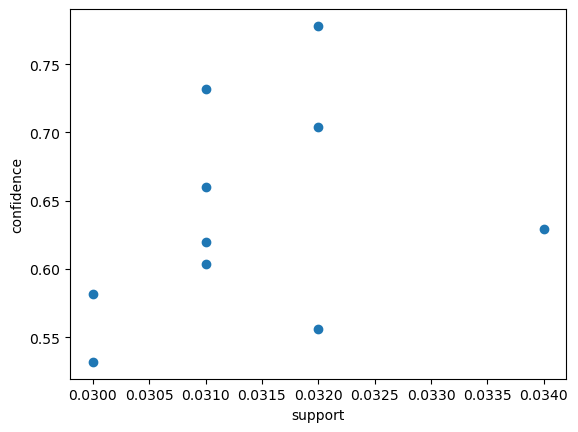

In [151]:
x=rules_apriori['support']
y=rules_apriori['confidence']
plt.scatter(x, y)
plt.xlabel('support')
plt.ylabel('confidence')
plt.show()

In [171]:
rules_fpgrowth= association_rules(frequent_itemsets_fpgrowth,metric="lift", min_threshold=1 ).round(decimals =3)
rules_fpgrowth=rules_fpgrowth[(rules_fpgrowth['confidence']>=0.5)]
rules_fpgrowth

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(82494L),(82482),0.052,0.057,0.030,0.582,10.282,0.027,2.259
1,(82482),(82494L),0.057,0.052,0.030,0.532,10.282,0.027,2.025
2,(22386),(85099B),0.055,0.097,0.034,0.629,6.477,0.029,2.434
4,(22726),(22727),0.046,0.051,0.031,0.660,13.010,0.028,2.795
5,(22727),(22726),0.051,0.046,0.031,0.604,13.010,0.028,2.408
6,(22384),(20725),0.057,0.076,0.032,0.556,7.342,0.027,2.080
14,(22697),(22699),0.041,0.045,0.032,0.778,17.106,0.030,4.299
15,(22699),(22697),0.045,0.041,0.032,0.704,17.106,0.030,3.238
16,(23300),(23301),0.042,0.050,0.031,0.732,14.715,0.029,3.545
17,(23301),(23300),0.050,0.042,0.031,0.620,14.715,0.029,2.523


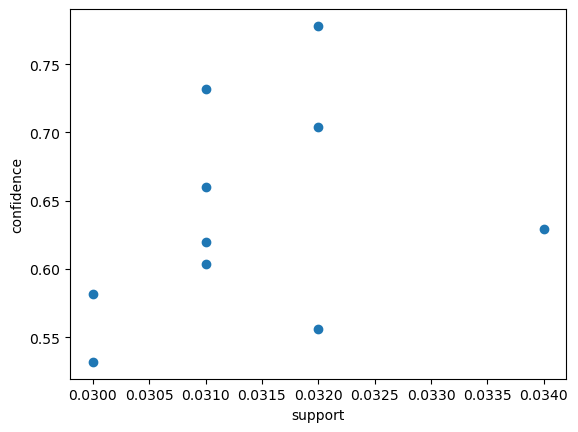

In [153]:
x=rules_fpgrowth['support']
y=rules_fpgrowth['confidence']
plt.scatter(x, y)
plt.xlabel('support')
plt.ylabel('confidence')
plt.show()

#### Checking the rules when the support is larger than 0.028 (2.8%) and confidence is larger than 0.5 (50%).

 support is 0.02 (2%)

In [175]:
frequent_itemsets_fpgrowth=fpgrowth(transactions, min_support=0.02, use_colnames=True)
rules_fpgrowth= association_rules(frequent_itemsets_fpgrowth,metric="lift", min_threshold=1 ).round(decimals =3)
rules_fpgrowth=rules_fpgrowth[(rules_fpgrowth['confidence']>=0.5)]
print(rules_fpgrowth.shape)
rules_fpgrowth

/home/pkeskin/anaconda3/envs/COMP47750/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


(43, 9)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(82494L),(82482),0.052,0.057,0.030,0.582,10.282,0.027,2.259
1,(82482),(82494L),0.057,0.052,0.030,0.532,10.282,0.027,2.025
3,(21733),(85123A),0.043,0.126,0.029,0.674,5.346,0.023,2.681
6,(22386),(85099B),0.055,0.097,0.034,0.629,6.477,0.029,2.434
8,(21931),(85099B),0.048,0.097,0.028,0.570,5.867,0.023,2.099
10,(85099C),(85099B),0.042,0.097,0.023,0.556,5.726,0.019,2.034
12,(21929),(85099B),0.037,0.097,0.020,0.547,5.635,0.017,1.994
14,(22411),(85099B),0.050,0.097,0.025,0.508,5.232,0.021,1.836
16,(22726),(22727),0.046,0.051,0.031,0.660,13.010,0.028,2.795
17,(22727),(22726),0.051,0.046,0.031,0.604,13.010,0.028,2.408


 support is larger than 0.028 (2.8%)

In [178]:
frequent_itemsets_fpgrowth=fpgrowth(transactions, min_support=0.028, use_colnames=True)
rules_fpgrowth= association_rules(frequent_itemsets_fpgrowth,metric="lift", min_threshold=1 ).round(decimals =3)
rules_fpgrowth=rules_fpgrowth[(rules_fpgrowth['confidence']>=0.5)]
print(rules_fpgrowth.shape)
rules_fpgrowth

/home/pkeskin/anaconda3/envs/COMP47750/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


(13, 9)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(82494L),(82482),0.052,0.057,0.030,0.582,10.282,0.027,2.259
1,(82482),(82494L),0.057,0.052,0.030,0.532,10.282,0.027,2.025
3,(21733),(85123A),0.043,0.126,0.029,0.674,5.346,0.023,2.681
4,(22386),(85099B),0.055,0.097,0.034,0.629,6.477,0.029,2.434
6,(22726),(22727),0.046,0.051,0.031,0.660,13.010,0.028,2.795
7,(22727),(22726),0.051,0.046,0.031,0.604,13.010,0.028,2.408
9,(22910),(22086),0.046,0.063,0.030,0.654,10.343,0.027,2.706
10,(22384),(20725),0.057,0.076,0.032,0.556,7.342,0.027,2.080
12,(22384),(20727),0.057,0.067,0.030,0.521,7.780,0.026,1.949
22,(22697),(22699),0.041,0.045,0.032,0.778,17.106,0.030,4.299


When minimum support gets larger number of candidates increase such that at 0.02 number of candidates was 43 but at 0.028 number of candidates was 13. Same goes for confidence when it increased number of candidates decrease. These result makes sense as support is how frequent item set appear in dataset and confidence is percentage of transactions having one item also have the other item. So, when we reduce support, we let less frequent pairs in and when we reduce confidence we let items with less pairing chance in. 

#### Drawing the map for the most important association rules

In [154]:
rules_fpgrowth_pivot=rules_fpgrowth.pivot("support","confidence","lift")
rules_fpgrowth_pivot.round(decimals =2)

confidence,0.532,0.556,0.582,0.604,0.620,0.629,0.660,0.704,0.732,0.778
support,,,,,,,,,,
0.030,10.28,NaN,10.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.031,NaN,NaN,NaN,13.01,14.72,NaN,13.01,NaN,14.72,NaN
0.032,NaN,7.34,NaN,NaN,NaN,NaN,NaN,17.11,NaN,17.11
0.034,NaN,NaN,NaN,NaN,NaN,6.48,NaN,NaN,NaN,NaN


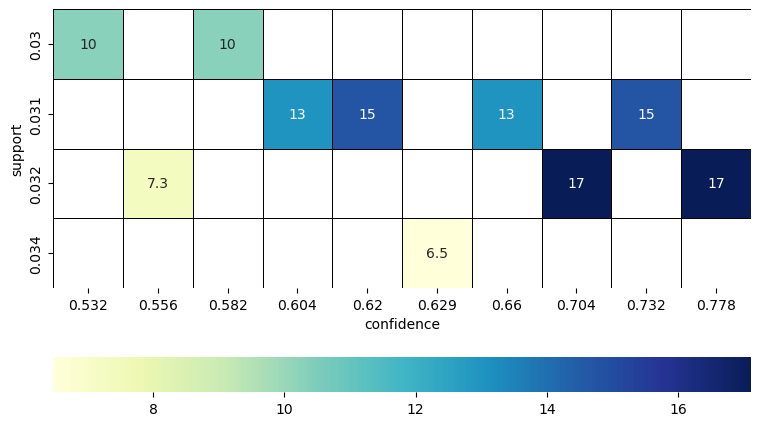

In [167]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(rules_fpgrowth_pivot, annot=True, linewidths=.5, ax=ax, linecolor='black', square=True, cmap="YlGnBu", cbar_kws={"orientation": "horizontal"})
plt.show()